<a href="https://colab.research.google.com/github/alik604/Notebooks/blob/master/my%20first%20LSTM%20-SPY%20pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional , CuDNNLSTM
import math
from sklearn.metrics import mean_squared_error
!pip install pandas-datareader
from pandas_datareader import data as pdr
!pip install fix-yahoo-finance
import fix_yahoo_finance as yf

Using TensorFlow backend.


In [9]:
share = 'SPY'
dataset = yf.download(share) #, start="2017-01-01"
#dataset =data.drop(columns=['Open','High', 'Low','Adj Close','Volume'])
dataset.head()


[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.9687,43.9687,43.7500,43.9375,26.954851,1003200
1993-02-01,43.9687,44.2500,43.9687,44.2500,27.146563,480500
1993-02-02,44.2187,44.3750,44.1250,44.3437,27.204052,201300
1993-02-03,44.4062,44.8437,44.3750,44.8125,27.491642,529400
1993-02-04,44.9687,45.0937,44.4687,45.0000,27.606684,531500


In [10]:

dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-04,247.589996,253.110001,247.169998,252.389999,252.389999,142628800
2019-01-07,252.690002,255.949997,251.690002,254.380005,254.380005,103139100
2019-01-08,256.820007,257.309998,254.000000,256.769989,256.769989,102512600
2019-01-09,257.559998,258.910004,256.190002,257.970001,257.970001,95006600
2019-01-10,256.260010,259.160004,255.500000,258.880005,258.880005,96562400


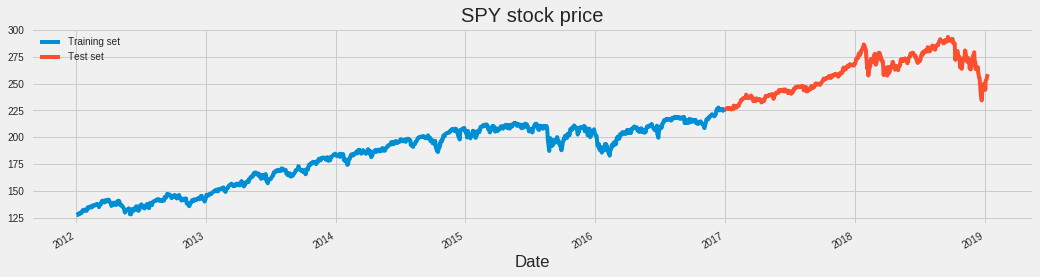

In [15]:
# Checking for missing values
training_set = dataset['2012':'2016'].iloc[:,0:1].values  #2010 or 2012
test_set = dataset['2018':].iloc[:,0:1].values
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["Close"]['2012':'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title(share+' stock price')
plt.show()

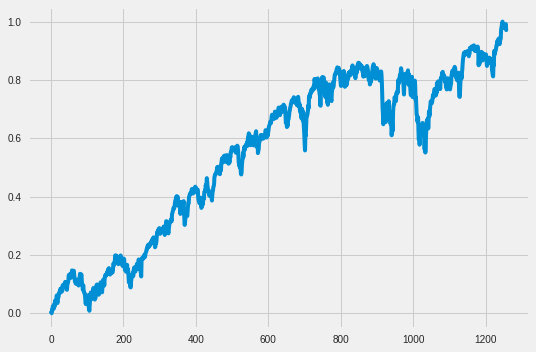

In [16]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

plt.plot(training_set_scaled)
plt.show()

In [0]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []

previous = 30

for i in range(previous,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-previous:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
# Reshaping X_train for efficient modelling

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1228, 30, 1)

In [19]:

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1228/1228 [==============================] - 13s 10ms/step - loss: 0.0515
Epoch 2/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0079
Epoch 3/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0056
Epoch 4/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0055
Epoch 5/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0049
Epoch 6/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0046
Epoch 7/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0051
Epoch 8/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0043
Epoch 9/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0040
Epoch 10/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0037
Epoch 11/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0037
Epoch 12/50
1228/1228 [==============================] - 9s 7ms/step - loss: 0.0036

[256.26001] [254.38995]


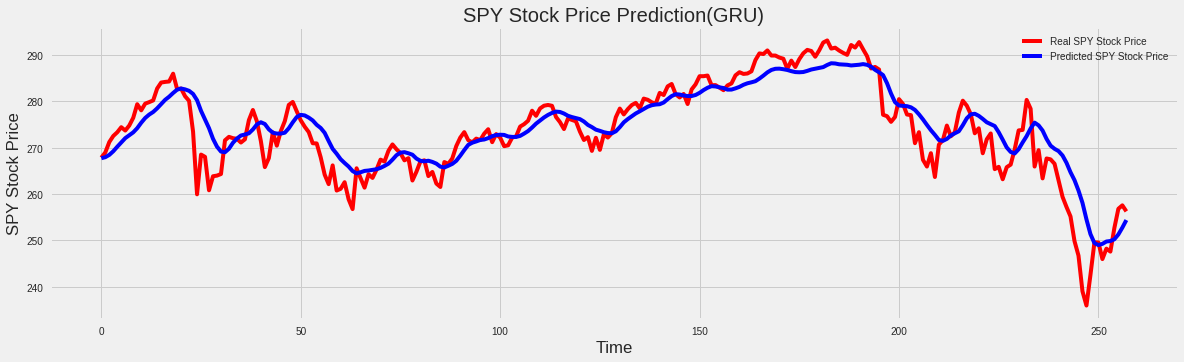

In [24]:
import pandas as pd
# testing the model
dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2018':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - previous:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(previous,len(inputs)):
    X_test.append(inputs[i-previous:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressorGRU.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


####################################################
print(test_set[-1],predicted_stock_price[-1])
# Visualizing the results
plt.figure(figsize=(18,5))
plt.plot(test_set[:], color='red',label='Real '+share+ ' Stock Price')
plt.plot(predicted_stock_price[:], color='blue',label='Predicted '+share+' Stock Price')
plt.title(share+' Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel(share+' Stock Price')
plt.legend()
plt.show()

In [21]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 15.054127944531752.


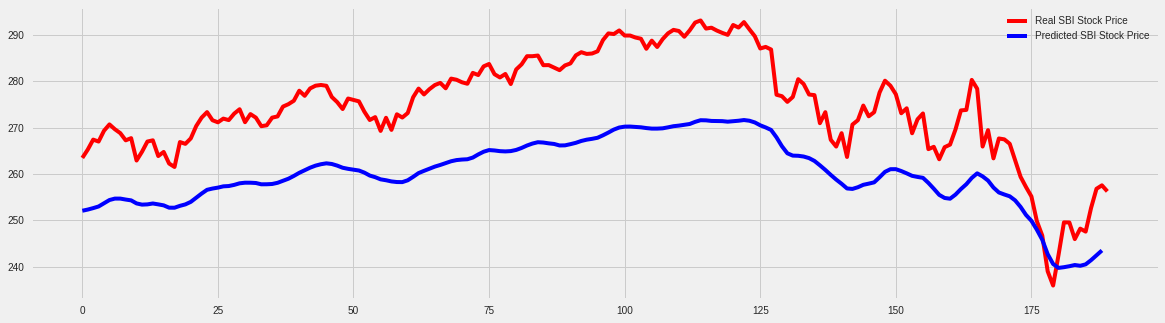

In [22]:
# print("prid",predicted_stock_price[len(predicted_stock_price)-1])
# print("test_set",test_set[len(test_set)-1])
# dataset.tail()

prev = predicted_stock_price[len(predicted_stock_price)-2]
current = predicted_stock_price[len(predicted_stock_price)-1]

diff =  current[0] - prev[0]

_prev = test_set[len(test_set)-2]
_current = test_set[len(test_set)-1]

_diff = _current[0] - _prev[0]


pred = predicted_stock_price
# plt.figure(figsize=(10,5))
plt.figure(figsize=(18,5))
plt.plot(test_set[-190:], color='red',label='Real SBI Stock Price')
plt.plot(predicted_stock_price[-189:], color='blue',label='Predicted SBI Stock Price')
plt.legend()
plt.show()
# print("predicted 1 day ahead",prev,current,diff)
# print("real last",_current,current,_diff)

In [23]:
# just trying
# last_pred = predicted_stock_price
new_pred = []
scaled_t = sc.fit_transform(test_set[-31:-1])
scaled_t = np.array([scaled_t])

p = regressorGRU.predict(scaled_t)

print("last real",sc.inverse_transform(scaled_t[-1]))
print("forcast",sc.inverse_transform(p))

last real [[265.779999]
 [266.339996]
 [269.600006]
 [273.709991]
 [273.809998]
 [280.279999]
 [278.369995]
 [265.920013]
 [269.459991]
 [263.369995]
 [267.660004]
 [267.470001]
 [266.519989]
 [262.959991]
 [259.399994]
 [257.200012]
 [255.169998]
 [249.860001]
 [246.740005]
 [239.039993]
 [235.970001]
 [242.570007]
 [249.580002]
 [249.559998]
 [245.979996]
 [248.229996]
 [247.589996]
 [252.690002]
 [256.820007]
 [257.559998]]
forcast [[251.81924]]
